In [ ]:
%matplotlib  qt

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hyperspy.api as hs
import numpy as np
import pyxem as pxm

from diffsims.generators.diffraction_generator import DiffractionGenerator
from diffsims.libraries.structure_library import StructureLibrary
from diffsims.generators.library_generator import DiffractionLibraryGenerator
from diffsims.generators.zap_map_generator import get_rotation_from_z_to_direction
from pyxem.generators.indexation_generator import IndexationGenerator
from hyperspy.signals import Signal2D

#from pyxem.utils.indexation_utils import peaks_from_best_template


In [5]:
dp = hs.load(r'C:\Users\ursulal\OneDrive - NTNU\2023_SIDI_project_ELKEM\20240104_SIDILam1\20240104_114935\cropped_centered.hspy')

In [ ]:
roi = hs.roi.RectangularROI(left=30, right=100, top=20, bottom=100)
dp.plot(norm='symlog')
roi.add_widget(dp)


In [ ]:
dp = roi(dp)

In [ ]:
rebinned = dp.rebin(scale=(1, 1, 2,2))

In [ ]:
dp.plot()

In [ ]:
rebinned.plot()

In [ ]:
dp = rebinned # to test things - binning in signal space

In [6]:
dp.axes_manager[0].scale = 100.47
dp.axes_manager[1].scale = 100.47
dp.axes_manager[2].scale = 1/100.47
dp.axes_manager[3].scale = 1/100.47
dp.axes_manager[0].units = "A"
dp.axes_manager[1].units = "A"
dp.axes_manager[2].units = "1/A"
dp.axes_manager[3].units = "1/A"
dp.axes_manager

Navigation axis name,size,index,offset,scale,units
,70,0,63.0,100.47,A
,80,0,81.0,100.47,A
Signal axis name,size,,offset,scale,units
,256,,0.0,0.009953219866626855,1/A
,256,,0.0,0.009953219866626855,1/A


In [ ]:
%matplotlib  inline

## 1. Visualising the SPED dataset
A quick way to get an overview of all the diffraction spots within the dataset, is to plot the maximum intensity with repsect to detector position. We can also look at the average to get a quick impression of the dataset.

In [ ]:
dp_max = dp.max()
dp_mean = dp.mean()

The colormap used in matplotlib can be specified when plotting a hyperpsy signal. For demonstration purposes various of the perceptially uniform colormaps is used within this notebook. An overview of available colourmaps can be found on the Matplotlib pages: https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html

In [ ]:
dp_max.plot(cmap='inferno', norm='log')
dp_mean.plot(cmap='inferno', norm='log')

Plot the SPED signal and navigate thorugh it to see the various precipitate reflections appearing.

In [ ]:
dp.plot(cmap='magma')

Plotting the patterns on a log scale makes it easier to see the weak precipitate Bragg spots. This can also be achieved by right clicking on the pattern and pressing 'l' on the keyboard.

In [ ]:
dp.plot(cmap='magma_r', norm='symlog')

The axes manager is useful to see the size of the dataset and the calibrations in both real and reciprocal space. Double check the scaling.

In [ ]:
dp.axes_manager

We save the calibration in reciprocal space to a variable, for easy use later.

In [7]:
calibration = dp.axes_manager[2].scale
calibration

0.009953219866626855

Virtual imaging can readily be done by defining a region of interest, which will be used as our integration window. We will use a circular aperture to obtan virtual STEM imaging. We can define a virtual bright field (VBF), virtual annular dark field (VADF), or a virtual dark field (VDF) aperture. For this dataset, the precipitates appear bright especially if a VADF aperture is placed in between the spots.



In [ ]:
roi = hs.roi.CircleROI(cx=0, cy=0, r=20*calibration, r_inner=10*calibration)

We can plot the integrated intensity from within the integration window, which will appear in a new window. You can use the navigator to move to a new scan position, and you can use the mouse to move the virtual aperture and change its size.



In [ ]:
dp.plot_integrated_intensity(roi)

The value of 'roi' is updated as you drag it around and change its size using the mouse. Print out the current 'roi'.

In [ ]:
roi

## Blob detection using scikit image

# Masking out background
Now that blob detection works, set the background outside the spts to -1

In [ ]:
len(dp.data)

In [ ]:
import numpy as np
from skimage.feature import blob_log
from skimage import draw
from skimage.transform import rescale
from scipy.ndimage import gaussian_filter
import hyperspy.api as hs

# Parameters for blob detection
max_sigma = 30
threshold = 3
diffraction_patterns = dp.data
diffraction_patterns = gaussian_filter(dp.data, sigma = 1)

# Create an empty array to store the summed intensities
summed_intensities = np.empty((diffraction_patterns.shape[0], diffraction_patterns.shape[1]))

# Initialize processed_patterns with zero arrays instead of None
processed_patterns = np.zeros_like(diffraction_patterns)
for i in range(processed_patterns.shape[0]):
    for j in range(processed_patterns.shape[1]):
        processed_patterns[i, j] = np.zeros((256, 256))
        
# Process each diffraction pattern
for row in range(diffraction_patterns.shape[0]):
    for col in range(diffraction_patterns.shape[1]):
        pattern = diffraction_patterns[row, col].copy()  # Make a copy of the pattern

        # Detect blobs using LoG method
        blobs = blob_log(pattern, max_sigma=max_sigma, threshold=threshold)
        blobs[:, 2] = blobs[:, 2] * np.sqrt(2)  # Compute radii

        # Create a high resolution mask with the same shape as the pattern, initialized with -1
        mask = np.full_like(pattern, -1, dtype=np.float64)
        mask_high_res = rescale(mask, 10, order=0, mode='constant', cval=-1, clip=True, preserve_range=True)

        # Draw blobs onto the high resolution mask
        for blob in blobs:
            y, x, r = blob
            rr, cc = draw.disk((y*10, x*10), r*10, shape=mask_high_res.shape)
            mask_high_res[rr, cc] = 1  # Set the pixel values at the blob locations to 1 in the mask

        # Downsample the high resolution mask to the original resolution
        mask = rescale(mask_high_res, 0.1, order=1, mode='reflect', cval=0, clip=True, preserve_range=True)
        mask = np.round(mask).astype(np.int64)

        # Set the area outside the blobs to -1
        pattern[mask == -1] = -1

        # Only add the pattern to the processed_patterns array if it is not None
        if pattern is not None:
            processed_patterns[row, col] = pattern
            
        # Create an empty array to store the summed intensities
        summed_intensities = np.empty((len(dp.data), len(dp.data)))

        # Sum the intensities of the pattern and store it in the summed_intensities array
        for i in range(len(dp.data)):
            for j in range(len(dp.data)):
                summed_intensities[i, j] = np.sum(processed_patterns[i, j])

# Create a Signal2D object with the summed intensities as the navigation signal
navigator = hs.signals.Signal2D(summed_intensities)

# Create a Diffraction2D hyperspy object with the processed patterns as the signal
dp_blob_diffraction = hs.signals.Signal2D(processed_patterns)

# Transpose the axes of the Diffraction2D object
dp_blob_diffraction = dp_blob_diffraction.transpose(signal_axes=[2, 3], navigation_axes=[0, 1])

# Set the navigator of the Diffraction2D object
dp_blob_diffraction.plot(navigator=navigator)


In [ ]:
dp_blob_diffraction.save(r'C:\Users\ursulal\OneDrive - NTNU\2023_SIDI_project_ELKEM\20240104_SIDILam1\20240104_114935\dp_masked.hspy')

In [ ]:
dp = dp_blob_diffraction

In [ ]:
dp.plot()

## An attempt of vectorization and parallelization - 240315

In [ ]:
import numpy as np
from skimage.feature import blob_log
from skimage import draw
from skimage.transform import rescale
import hyperspy.api as hs
from multiprocessing import Pool
from scipy.ndimage import gaussian_filter

# Parameters for blob detection
max_sigma = 30
threshold = 4
diffraction_patterns = dp.data
diffraction_patterns = gaussian_filter(dp.data, sigma = 1)

# Initialize processed_patterns with zero arrays instead of None
processed_patterns = np.zeros_like(diffraction_patterns)


In [ ]:
def process_pattern(pattern):
    # Detect blobs using LoG method
    blobs = blob_log(pattern, max_sigma=max_sigma, threshold=threshold)
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2)  # Compute radii

    # Create a high resolution mask with the same shape as the pattern, initialized with -1
    mask = np.full_like(pattern, -1, dtype=np.float64)
    mask_high_res = rescale(mask, 10, order=0, mode='constant', cval=-1, clip=True, preserve_range=True)

    # Draw blobs onto the high resolution mask
    for blob in blobs:
        y, x, r = blob
        rr, cc = draw.disk((y*10, x*10), r*10, shape=mask_high_res.shape)
        mask_high_res[rr, cc] = 1  # Set the pixel values at the blob locations to 1 in the mask

    # Downsample the high resolution mask to the original resolution
    mask = rescale(mask_high_res, 0.1, order=1, mode='reflect', cval=0, clip=True, preserve_range=True)
    mask = np.round(mask).astype(np.int64)

    # Set the area outside the blobs to -1
    pattern[mask == -1] = -1

    return pattern


In [ ]:
# Create a pool of workers
with Pool() as p:
    # Flatten the diffraction_patterns array and apply the process_pattern function to each pattern
    processed_patterns = np.array(p.map(process_pattern, diffraction_patterns.reshape(-1, diffraction_patterns.shape[-1], diffraction_patterns.shape[-1])))


In [ ]:
# Reshape the processed_patterns array back to its original shape
processed_patterns = processed_patterns.reshape(diffraction_patterns.shape)

# Sum the intensities of the pattern and store it in the summed_intensities array
summed_intensities = np.sum(processed_patterns, axis=(2,3))

# Create a Signal2D object with the summed intensities as the navigation signal
navigator = hs.signals.Signal2D(summed_intensities)

# Create a Diffraction2D hyperspy object with the processed patterns as the signal
dp_blob_diffraction = hs.signals.Signal2D(processed_patterns)

# Transpose the axes of the Diffraction2D object
dp_blob_diffraction = dp_blob_diffraction.transpose(signal_axes=[2, 3], navigation_axes=[0, 1])

# Set the navigator of the Diffraction2D object
dp_blob_diffraction.plot(navigator=navigator)


In [ ]:
dp.find_peaks()

# Blob  detection using hyperspy map function 
It seems that the map function is slower

In [ ]:
import numpy as np
from skimage.feature import blob_log
from skimage import draw
from scipy.ndimage import gaussian_filter
import hyperspy.api as hs

# Parameters for blob detection
max_sigma = 30
threshold = 5
diffraction_patterns = gaussian_filter(dp.data, sigma = 1)# dp.data #

# the simulated patterns we need a mean radius 
r_list = []

# Define a function to process a diffraction pattern
def process_diffraction_pattern(pattern):
    # Detect blobs using LoG method
    blobs = blob_log(pattern, max_sigma=max_sigma, threshold=threshold)
    blobs[:, 2] = blobs[:, 2] * np.sqrt(2)  # Compute radii in the correct scale

    # Create a mask with the same shape as the pattern, initialized with -1
    mask = np.full_like(pattern, -1)

    # Draw blobs onto the mask
    for blob in blobs:
        y, x, r = blob
        r_list.append(r)
        rr, cc = draw.disk((y, x), r, shape=pattern.shape)
        mask[rr, cc] = 1  # Set the pixel values at the blob locations to 1 in the mask

    # Set the area outside the blobs to -1
    pattern[mask == -1] = -1

    return pattern

# Apply the function to each diffraction pattern in the dataset
dp.map(process_diffraction_pattern, inplace=True)

# Now let's plot the processed patterns with overlays
dp.plot()


## The mean value of the diffraction disks & mean value in 


In [ ]:
avg_r = np.mean(r_list)

## Creating template libraries
Sampling orientations and simulating diffraction
# Finding the in-plane rotation of the average pattern
Import the crystal information file (cif) for each of the  phases using diffpy. This file contains information on the space group, lattice parameters, atom sites, atom types and site occupations.

In [4]:
import diffpy
structure_aFe = diffpy.structure.loadStructure(r'C:\Users\ursulal\OneDrive - NTNU\2023_SIDI_project_ELKEM\cif\Fe_mp-13_conventional_standard.cif')
structure_FeC = diffpy.structure.loadStructure(r'C:\Users\ursulal\OneDrive - NTNU\2023_SIDI_project_ELKEM\cif\Fe3C_mp-510623_conventional_standard.cif')
structure_MnS = diffpy.structure.loadStructure(r'C:\Users\ursulal\OneDrive - NTNU\2023_SIDI_project_ELKEM\cif\MnS.cif')

Set up a diffraction generator using diffsims. This generator contains information on the microscope settings, most importantly the incident beam energy, and it will be used ater for simulating diffraction.

In [8]:
from diffsims.generators.diffraction_generator import DiffractionGenerator
diff_gen = DiffractionGenerator(accelerating_voltage=200.)

We also set up a generator that will be used in creating a library of simulated diffraction patterns. This library generator takes the diffraction generator as input.



In [9]:
from diffsims.generators.library_generator import DiffractionLibraryGenerator
lib_gen = DiffractionLibraryGenerator(diff_gen)

First, we will focus on the average pattern from the whole dataset. This pattern shows the Fe matrix oriented to (or very close to) the zone axis <100>. We aim to simulate a diffraction pattern that matches this average pattern.

Create a structure library containing the phase identifier, the crystal structure and the orientations that will be used to simulate diffraction. For now, we will only lookt the crystalum oriented to Euler angles (0,0,0), which will leave the crystl oriented to the <100> zone axi In the context of crystallography and electron diffraction, the term “zone axis” refers to a direction in a crystal lattice. When we say a crystal is oriented along a certain zone axis, we mean that the electron beam is parallel to that direction.

So, if the Euler angles are (0,0,0), it means the crystal orientation is the same as the reference orientation. The specific zone axis corresponding to this orientation depends on the reference state of the crystal. For a cubic crystal system, if the reference state is aligned along the [100] direction, then the Euler angles (0,0,0) would correspond to the [100] zone a

This is suitable for materials, like Al, where [100] is the most used orientation. In case of Fe allotrpes it might be better to start with a random zone axis.
On 240112 the zone axis for testing the notebook is [111] and has the Euler angles (90., 54.736, 45.).s.s.

In [14]:
from diffsims.libraries.structure_library import StructureLibrary
euler_100 = (90., 54.736, 45.) # <111> zone axis # (0., 0., 0.) # <100> zone axis 
library_Fe = StructureLibrary(identifiers = ['Fe'], 
                              structures = [structure_aFe], 
                              orientations = [[euler_100]])

# Cementite FeC

Define variables needed to simulate diffraction. We know the length of the detector and can use that to calculate how far into reciprocal space we need to simulate diffraction for ('reciprocal_radius'), in order to cover the whole detector, using Pythagoras.

In [15]:
half_shape = (64, 64) # FIXME check values
reciprocal_radius = np.sqrt(64**2*2)*calibration
reciprocal_radius

0.9008626255785618

We also need to determine the maximum excitation error in the diffraction simulation. This parameter can very roughly be interpreted as the relrod length ans is related to the inverse thickness of the specimen.



In [16]:
max_excitation_error = 1/10

Calculate the library of simulated diffraction patterns, for the structure library defined above, which contained only the aFe and the orientation (0,0,0).



In [17]:
diff_lib_Fe = lib_gen.get_diffraction_library(library_Fe,
                                              calibration=calibration,
                                              reciprocal_radius=reciprocal_radius,
                                              half_shape=half_shape,
                                              with_direct_beam=False,
                                              max_excitation_error=max_excitation_error)

This simulated library contains for each simulated pattern, the phase, the orientation, the center coordinates of the simulated Bragg spots, their intensities and their indices hkl.

In [18]:
diff_lib_Fe

{'Fe': {'simulations': array([<diffsims.sims.diffraction_simulation.DiffractionSimulation object at 0x00000223B5C8FD50>],
        dtype=object),
  'orientations': [(90.0, 54.736, 45.0)],
  'pixel_coords': array([array([[107, -11],
                [151,  64],
                [107,  39],
                [ 64,  14],
                [ 21, -11],
                [107,  89],
                [ 21,  39],
                [107, 139],
                [ 64, 114],
                [ 21,  89],
                [-23,  64],
                [ 21, 139]])], dtype=object),
  'intensities': array([array([10.33895331, 10.33843889, 34.6761252 , 34.67674383, 10.33998184,
                34.6761252 , 34.67736189, 10.33895331, 34.67674383, 34.67736189,
                10.34049593, 10.33998184])                                      ],
        dtype=object)}}

We pick out the first (and only) simulation and plot it.



In [373]:
simulation_Fe = diff_lib_Fe['Fe']['simulations'][0]
#simulation_Fe.plot()


In [ ]:
simulation_Fe.indices

We see that the simulation and indices fit what was expected. However, we do not know the in-plane rotation of the spots, which we can calculate. This is done by calculating the polar transforms of both the pattern and the simulation and calculating their cross correlation coefficient as one is shifted over the other.

In [21]:
from pyxem.utils import indexation_utils as iutls
a, c = iutls.get_in_plane_rotation_correlation(dp_mean.data, simulation_Fe)

NameError: name 'dp_mean' is not defined

Define the in-plane angle as the angle with the highest correlation score.

In [20]:
in_plane_angle = a[np.argmax(c)]
in_plane_angle

NameError: name 'a' is not defined

We plot the simulated spots on top of the average pattern. With the correct in-plane rotation applied, there is

In [ ]:
from pyxem.utils import plotting_utils as putls
from matplotlib.colors import LogNorm
putls.plot_template_over_pattern(dp_mean.data,
                                 simulation_Fe,
                                 in_plane_angle=in_plane_angle,
                                 norm=LogNorm())

## Sampling orientations within the fundamental sector
Next we want to create a list of orientations sampled from the whole fundamental sector of the respective crystal system. This does not take into account the in-plane rotations, only the beam directions.

We set an angular resolution for creation of the grid of orientations.

In [22]:
resolution = 1 # What does angular resolution mean?

In [23]:
from diffsims.generators.rotation_list_generators import get_beam_directions_grid
grid_aFe = get_beam_directions_grid(
    resolution=resolution, crystal_system = "cubic") # Ferrite
grid_FeC = get_beam_directions_grid(
    resolution=resolution, crystal_system = "orthorhombic") # FeC
grid_MnS = get_beam_directions_grid(
    resolution=resolution, crystal_system = "cubic") # MnS

C:\Users\ursulal\AppData\Local\miniconda3\envs\2312_hspy\Lib\site-packages\diffsims\generators\sphere_mesh_generators.py:514: RuntimeWarning: invalid value encountered in divide
  phi2 = sign * np.nan_to_num(np.arccos(x_comp / norm_proj))




Due to the various symmetries of the three lattice types, the length of the grids are quite different.



In [24]:
print(len(grid_aFe), len(grid_FeC), len(grid_MnS))


1081 6211 1081


Define the Laue group symmetry of each of the three phases. Here, Schoenflies notation is used. Take a look at the orix documentation to find an overview of the 32 point groups and the corresponding 11 Laue groups. https://orix.readthedocs.io/en/stable/inverse_pole_figures.html - the link is not working

In [25]:
from orix.quaternion import symmetry, Orientation, Rotation
symmetry_aFe = symmetry.Oh
symmetry_FeC = symmetry.D2h
symmetry_MnS = symmetry.Oh

These contain all the allowed symmetry operations.

In [26]:
symmetry_aFe
symmetry_FeC
symmetry_MnS

Symmetry (48,) m-3m
[[ 1.      0.      0.      0.    ]
 [ 0.7071  0.      0.      0.7071]
 [ 0.      0.      0.      1.    ]
 [-0.7071  0.      0.      0.7071]
 [ 0.5     0.5     0.5     0.5   ]
 [ 0.      0.      0.7071  0.7071]
 [-0.5    -0.5     0.5     0.5   ]
 [-0.7071 -0.7071  0.      0.    ]
 [ 0.      1.      0.      0.    ]
 [ 0.      0.7071  0.7071  0.    ]
 [ 0.      0.      1.      0.    ]
 [ 0.     -0.7071  0.7071  0.    ]
 [-0.5     0.5     0.5    -0.5   ]
 [ 0.      0.      0.7071 -0.7071]
 [ 0.5    -0.5     0.5    -0.5   ]
 [ 0.7071 -0.7071  0.      0.    ]
 [ 0.      0.7071  0.      0.7071]
 [-0.5     0.5     0.5     0.5   ]
 [-0.7071  0.      0.7071  0.    ]
 [-0.5    -0.5     0.5    -0.5   ]
 [ 0.      0.7071  0.     -0.7071]
 [ 0.5     0.5     0.5    -0.5   ]
 [ 0.7071  0.      0.7071  0.    ]
 [ 0.5    -0.5     0.5     0.5   ]
 [ 1.      0.      0.      0.    ]
 [ 0.7071  0.      0.      0.7071]
 [ 0.      0.      0.      1.    ]
 [-0.7071  0.      0.      0.7071]


Calculate the orientations from the grid of Euler angles, using the respective symmetries as input. The orientations are given as quaternions. Note that "In orix, orientations and misorientations are distinguished from rotations only by the inclusion of a notion of symmetry." - this needs more documentation

In [27]:
orientations_aFe = Orientation.from_euler(np.deg2rad(grid_aFe), symmetry=symmetry_aFe)
orientations_FeC = Orientation.from_euler(np.deg2rad(grid_FeC), symmetry=symmetry_FeC)
orientations_MnS = Orientation.from_euler(np.deg2rad(grid_MnS), symmetry=symmetry_MnS)

In [28]:
orientations_aFe

Orientation (1081,) m-3m
[[ 0.7071 -0.      0.     -0.7071]
 [ 0.7071 -0.0062  0.0062 -0.7071]
 [ 0.707  -0.0123  0.0123 -0.707 ]
 ...
 [ 0.8178 -0.4151  0.1805 -0.3556]
 [ 0.8192 -0.4198  0.1782 -0.3477]
 [ 0.8205 -0.4247  0.1759 -0.3399]]

Plot these orientations on the inverse pole figure (IPF).

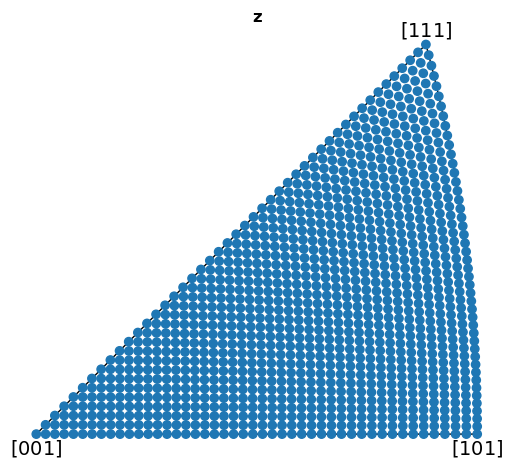

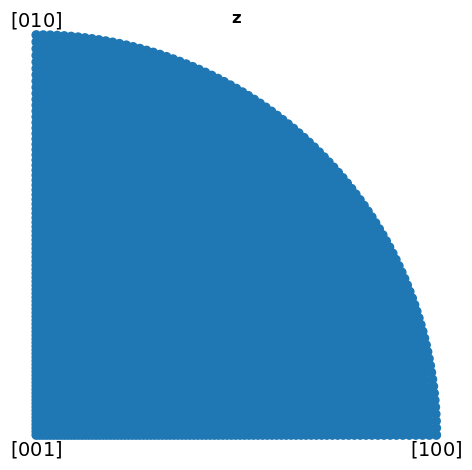

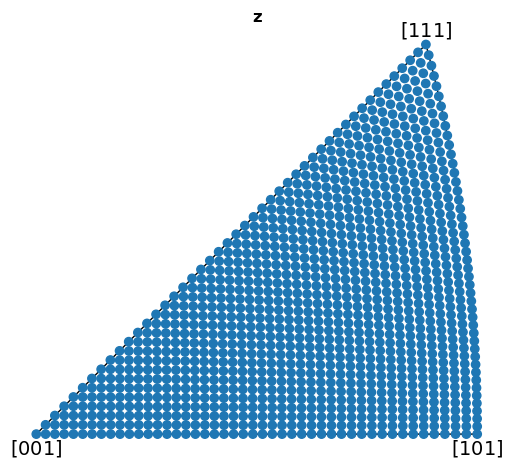

In [29]:
orientations_aFe.scatter('ipf')
orientations_FeC.scatter('ipf')
orientations_MnS.scatter('ipf')

Rotate the beam direction (optic axis) according to the crystal orientations.



In [30]:
from orix.vector import Vector3d, Miller
orientations_aFe_z = orientations_aFe * Vector3d.zvector() 
orientations_FeC_z = orientations_FeC * Vector3d.zvector()
orientations_MnS_z = orientations_MnS * Vector3d.zvector()

Plot the beam directions (the sampled zone axes) inside the upper hemisphere of the full [001] stereograpic projections 

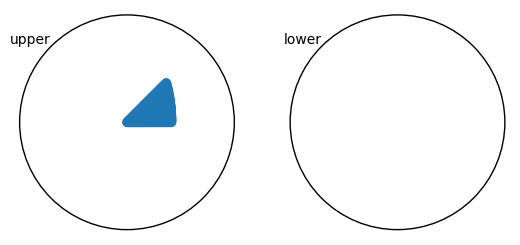

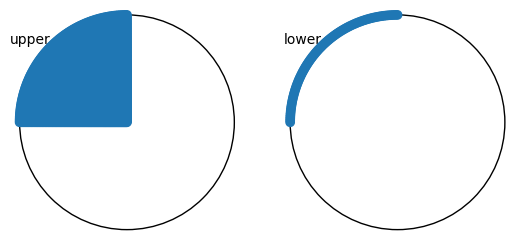

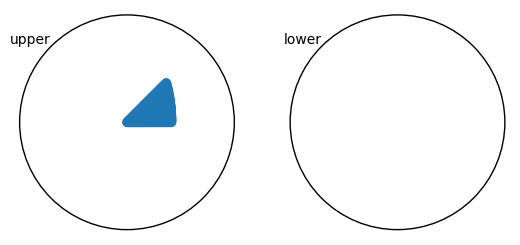

In [31]:
orientations_aFe_z.scatter(hemisphere="both") # 240205 error:'numpy.ndarray' object has no attribute 'scatter'
orientations_FeC_z.scatter(hemisphere="both")
orientations_MnS_z.scatter(hemisphere="both")

## 2c. Sampling orientations around a zone axis
Define each phase using the Phase class in orix, with the structure and symmetry as inpu

In [32]:
from orix.crystal_map import Phase


In [33]:
phase_aFe = Phase(structure=structure_aFe, point_group=symmetry_aFe)
phase_FeC = Phase(structure=structure_FeC, point_group=symmetry_FeC)
phase_MnS = Phase(structure=structure_MnS, point_group=symmetry_MnS)

Since the precipitates have specific orientation relationships with the aluminium matrix, we know what zone axis they should be close to when the matrix is oriented to zone axis [001]. If there are several zone axis that are equivalent by symmetry, we choose those that lie within the fundamental zone, since the grid of Euler angles we defined earlier was for the fundamental zone.

In [34]:
# Define the diffraction generator with a desired maximum excitation error
diff_gen = DiffractionGenerator(200, max_excitation_error=1/10)


In [35]:
# Define the rotation list
rotation_list = Rotation.from_euler(np.arange(0, 360, 1), degrees = True)

In [36]:
# Create a structure library
struc_lib = StructureLibrary(['phase_aFe', 'phase_FeC', 'phase_MnS'], [phase_aFe, phase_FeC, phase_MnS], [rotation_list]*3)


In [37]:
uvw_aFe = [1, 1, 1]
uvw_FeC = [0, 0, 1]
uvw_MnS = [1, 1, 1]

Define how far from the zone axis you want to sample orientations.



In [38]:
threshold_angle =10

In [39]:
def reduce_beam_directions(phase, grid, orientations_z, zone_axis, threshold):
    za = Miller(uvw=zone_axis, phase=phase)
    angles = orientations_z.angle_with(za)
    reduced_grid = grid[angles <= np.deg2rad(threshold)]

    return reduced_grid

In [40]:
grid_aFe_zone = reduce_beam_directions(
    phase_aFe, grid_aFe, orientations_aFe_z, uvw_aFe, threshold_angle)

grid_FeC_zone = reduce_beam_directions(
    phase_FeC, grid_FeC, orientations_FeC_z, uvw_FeC, threshold_angle)

grid_MnS_zone = reduce_beam_directions(
    phase_MnS, grid_MnS, orientations_MnS_z, uvw_MnS, threshold_angle)

We have now only sampled the orientations aorund the known zone axis for each phase, which reduced the list of orientations significantly. Compare the length of each grid to the length of the grids sampling the whole fundamental zone.

In [41]:
print(len(grid_aFe_zone), len(grid_FeC_zone), len(grid_MnS_zone))


78 88 78


## 2d. Simulating kinematical diffraction
Set up lists of the phases, their structures and the grid of orientations.

In [42]:
rotation_list


Rotation (1,)
[[ 0.9998 -0.0087  0.0002 -0.0175]]

In [43]:
# List of phase names:
phases = ['aFe', 'FeC', 'MnS']

# List of structures:
structures = [structure_aFe, structure_FeC, structure_MnS]

# List of rotations:
grids = [grid_aFe_zone, grid_FeC_zone, grid_MnS_zone]

Define a new structure library containing the phases, structures and grids, which we will use to simulate our diffraction patterns.

In [44]:
library = StructureLibrary(phases, structures, grids)

In [45]:
diff_lib = lib_gen.get_diffraction_library(library,
                                           calibration=calibration,c
                                           reciprocal_radius=reciprocal_radius,
                                           half_shape=half_shape,
                                           with_direct_beam=False,
                                           max_excitation_error= 1/10)#max_excitation_error)  0.08 

The diffraction library is a dictionary, which takes the phase names as key. The library of each phase can then be accessed using diff_lib['key']. Here we print the keys we have available.

In [46]:
diff_lib.keys() 

dict_keys(['aFe', 'FeC', 'MnS'])

Plot the simulation closest to zone-axis.



In [317]:
diff_lib['aFe']['simulations'][60].plot() # Closest to Euler angle (0, 0, 90)
#diff_lib['FeC']['simulations'][0].plot() # Closest to Euler angle (0, 90, 90)
#diff_lib['MnS']['simulations'][0].plot() # Closest to Euler angle (0, 54.4, 0)

(<Axes: >, <matplotlib.collections.PathCollection at 0x2245081d5d0>)

(<Axes: >, <matplotlib.collections.PathCollection at 0x223b5e3bc50>)

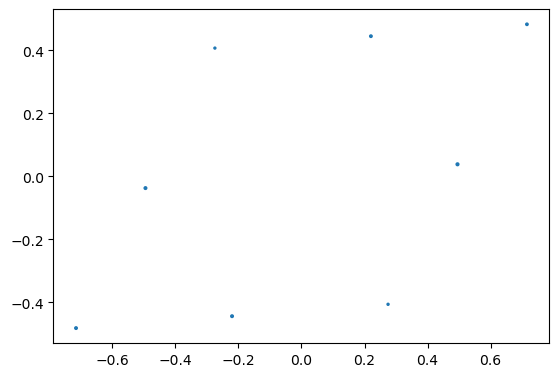

In [48]:
fig, axs = plt.subplots()
axs.set_aspect(1)
diff_lib['aFe']['simulations'][0].plot(ax=axs)

In [ ]:
s = hs.signals.BaseSignal(diff_lib['aFe']['simulations'], dtype= object, ragged= True)
len(diff_lib['aFe']['simulations'])

In [ ]:
currMax = 0
number = len(diff_lib['aFe']['simulations'])-1
for i in range(0,number):
    if (len(diff_lib['aFe']['simulations'][i])> currMax):
     currMax = len(diff_lib['aFe']['simulations'][i])
     maxIndex = i
   #  print(i,len(diff_lib['aFe']['simulations'][i]))#s.plot()#s#.axes_manager   #diff_lib['aFe']['simulations'][0]
print(maxIndex)   
  

In [ ]:
simulation# = diff_lib['aFe']['simulations']

## Here an attempt to make more realistic looking simulated diff patterns 
240312

In [203]:
diff_lib['aFe']['simulations'][10].calibrated_coordinates

array([[-70.12989737, -50.70575174],
       [  7.93062437, -85.80665519],
       [-20.733091  , -45.50413564],
       [-49.39680637,  -5.2016161 ],
       [ 28.66371537, -40.30251955],
       [-28.66371537,  40.30251955],
       [ 49.39680637,   5.2016161 ],
       [ 20.733091  ,  45.50413564],
       [ -7.93062437,  85.80665519],
       [ 70.12989737,  50.70575174]])

In [ ]:
peak_diam = 6
max_avg_int = 10

## That works!! 241219

In [361]:
# def create_gaussian(width, height, max_intensity):
#     """Create a 2D Gaussian. With this we have the option of defining an asymmetric Gaussian"""
#     sigma_x = width / 3.0
#     sigma_y = height / 3.0
#     x = np.linspace(-width / 2, width / 2, width)
#     y = np.linspace(-height / 2, height / 2, height)
#     x, y = np.meshgrid(x, y)
#     gaussian = max_intensity * np.exp(-(x**2 / (2.0 * sigma_x**2) + y**2 / (2.0 * sigma_y**2)))

#     # Apply a Hanning window to the Gaussian
#     window = np.outer(np.hanning(width), np.hanning(width))
#     gaussian *= window

#     return gaussian


def create_gaussian(size, _, max_intensity):  # Change 'width' and 'height' to 'size' and '_'
    """Create a round 2D Gaussian."""
    sigma = size / 3.0
    x = np.linspace(-size / 2, size / 2, size)
    y = np.linspace(-size / 2, size / 2, size)
    x, y = np.meshgrid(x, y)
    gaussian = max_intensity * np.exp(-(x**2 + y**2) / (2.0 * sigma**2))

    # Apply a Hanning window to the Gaussian
    window = np.outer(np.hanning(size), np.hanning(size))
    gaussian *= window

    return gaussian


# Parameters
peak_diam = 20  # Already in calibrated units
max_avg_int = 20  # Already in calibrated units

# Initialize an empty list to store the modified patterns
modified_patterns = []

# Get the simulations
simulations = diff_lib['aFe']['simulations']

# Find the maximum and minimum coordinates in all simulations
max_coord = np.max([np.max(sim.calibrated_coordinates) for sim in simulations])
min_coord = np.min([np.min(sim.calibrated_coordinates) for sim in simulations])

# Calculate the size of the largest pattern plus the additional Gaussian width
extra_padding = 20
pattern_size = int(max_coord - min_coord + 2*peak_diam + extra_padding)

# Loop over each simulation
for sim in simulations:
    # Create an empty 2D array with the fixed size
    modified_pattern = np.zeros((pattern_size, pattern_size))

    # Get the coordinates and shift them to the new coordinate system
    coordinates = sim.calibrated_coordinates - min_coord + 1.5*extra_padding #/ 2 usind e.p. of 1.5 leads to a more centered pattern

    # Loop over each peak in the simulation
    for peak in coordinates:
        # Define the center of the Gaussian
        center_x = int(peak[0])
        center_y = int(peak[1])
    
        # Define the region where the Gaussian will be added
        start_x = max(center_x - peak_diam // 2, 0)
        stop_x = min(center_x + peak_diam // 2, pattern_size)
        start_y = max(center_y - peak_diam // 2, 0)
        stop_y = min(center_y + peak_diam // 2, pattern_size)
        print(start_x, stop_x, start_y, stop_y)
        # Calculate the size of the region
        region_size = (stop_x - start_x, stop_y - start_y)
    
        # Create a 2D Gaussian with the desired intensity and the exact size of the region
        gaussian = create_gaussian(region_size[1], region_size[0], max_avg_int)
 #       gaussian = create_gaussian(*region_size, max_avg_int)
        
        # Add the Gaussian to the region of the modified pattern
        modified_pattern[start_x:stop_x, start_y:stop_y] += gaussian

    # Append the modified pattern to the list
    modified_patterns.append(modified_pattern)

# Find the size of the largest pattern
max_pattern_size = max(max(pattern.shape) for pattern in modified_patterns)

# Pad all patterns to the size of the largest pattern
padded_patterns = [np.pad(pattern, ((0, max_pattern_size - pattern.shape[0]), 
                                      (0, max_pattern_size - pattern.shape[1]))) 
                    for pattern in modified_patterns]

# Convert the list of padded patterns into a numpy array
padded_patterns_array = np.array(padded_patterns)

# Convert the numpy array into a HyperSpy Signal2D object
modified_patterns_signal = Signal2D(padded_patterns_array)
modified_patterns_signal.plot()
#modified_patterns_signal.save(r'sim.hspy')

34 54 58 78
84 104 62 82
56 76 102 122
134 154 65 85
79 99 147 167
156 176 110 130
128 148 151 171
178 198 155 175
35 55 57 77
85 105 61 81
57 77 102 122
134 154 66 86
78 98 147 167
156 176 110 130
128 148 151 171
177 197 155 175
35 55 56 76
85 105 61 81
57 77 101 121
134 154 66 86
78 98 147 167
156 176 111 131
127 147 151 171
177 197 156 176
36 56 55 75
114 134 21 41
85 105 61 81
57 77 101 121
135 155 66 86
77 97 146 166
156 176 112 132
127 147 152 172
176 196 157 177
33 53 61 81
83 103 62 82
56 76 104 124
133 153 64 84
80 100 148 168
182 202 66 86
156 176 108 128
130 150 150 170
180 200 152 172
33 53 60 80
83 103 62 82
56 76 104 124
133 153 65 85
79 99 148 168
183 203 67 87
156 176 109 129
129 149 150 170
179 199 153 173
34 54 59 79
84 104 62 82
56 76 103 123
133 153 65 85
79 99 147 167
156 176 109 129
129 149 151 171
179 199 154 174
34 54 58 78
84 104 61 81
56 76 102 122
134 154 65 85
79 99 147 167
156 176 110 130
128 148 151 171
178 198 155 175
35 55 57 77
112 132 20 40
84 104 61 8

## Here the code for creating Signal2D  objects from simulated data, that look more like real SPED data 
Here I use object oriented style so it is easier to work with simulations of different structures in the same dataset. The functions in the class are independent of the simulated data.

In [369]:
class GaussianPattern:
    def __init__(self, peak_diam, max_avg_int, extra_padding):
        self.peak_diam = peak_diam
        self.max_avg_int = max_avg_int
        self.extra_padding = extra_padding
        self.patterns = []

    def create_gaussian(self, size, _):
        sigma = size / 3.0
        x = np.linspace(-size / 2, size / 2, size)
        y = np.linspace(-size / 2, size / 2, size)
        x, y = np.meshgrid(x, y)
        gaussian = self.max_avg_int * np.exp(-(x**2 + y**2) / (2.0 * sigma**2))
        window = np.outer(np.hanning(size), np.hanning(size))
        gaussian *= window
        return gaussian

    def add_pattern(self, simulation):
        max_coord = np.max(simulation.calibrated_coordinates)
        min_coord = np.min(simulation.calibrated_coordinates)
        pattern_size = int(max_coord - min_coord + 2*self.peak_diam + self.extra_padding)
        modified_pattern = np.zeros((pattern_size, pattern_size))
        coordinates = simulation.calibrated_coordinates - min_coord + 1.5*self.extra_padding
        for peak in coordinates:
            center_x = int(peak[0])
            center_y = int(peak[1])
            start_x = max(center_x - self.peak_diam // 2, 0)
            stop_x = min(center_x + self.peak_diam // 2, pattern_size)
            start_y = max(center_y - self.peak_diam // 2, 0)
            stop_y = min(center_y + self.peak_diam // 2, pattern_size)
            region_size = (stop_x - start_x, stop_y - start_y)
            gaussian = self.create_gaussian(region_size[1], region_size[0])
            modified_pattern[start_x:stop_x, start_y:stop_y] += gaussian
        self.patterns.append(modified_pattern)

    def pad_patterns(self):
        max_pattern_size = max(max(pattern.shape) for pattern in self.patterns)
        return [np.pad(pattern, ((0, max_pattern_size - pattern.shape[0]), 
                                  (0, max_pattern_size - pattern.shape[1]))) 
                for pattern in self.patterns]

    def to_signal(self):
        padded_patterns_array = np.array(self.pad_patterns())
        return Signal2D(padded_patterns_array)



Here we execute and plot the simulated data of different structures:

In [374]:
# Usage:
gaussian_pattern = GaussianPattern(peak_diam=20, max_avg_int=20, extra_padding=20)
for sim in diff_lib['aFe']['simulations']:
    gaussian_pattern.add_pattern(sim)
signal = gaussian_pattern.to_signal()
signal.plot()


In [322]:
# Usage:
gaussian_pattern = GaussianPattern(peak_diam=20, max_avg_int=20, extra_padding=20)
for sim in diff_lib['FeC']['simulations']:
    gaussian_pattern.add_pattern(sim)
signal = gaussian_pattern.to_signal()
signal.plot()


<Signal2D, title: , dimensions: (78|185, 185)>

In [372]:
# Usage:
gaussian_pattern = GaussianPattern(peak_diam=20, max_avg_int=20, extra_padding=20)
for sim in diff_lib['MnS']['simulations']:
    gaussian_pattern.add_pattern(sim)
signal = gaussian_pattern.to_signal()
signal.plot()


In [312]:
modified_patterns_signal

<Signal2D, title: , dimensions: (78|185, 185)>

In [74]:
sim.calibrated_coordinates

array([[-71.8620349 , -48.41621023],
       [-22.13211059, -44.62412953],
       [-49.72992431,  -3.79208069],
       [ 27.59781371, -40.83204884],
       [-27.59781371,  40.83204884],
       [ 49.72992431,   3.79208069],
       [ 22.13211059,  44.62412953],
       [ 71.8620349 ,  48.41621023]])

In [ ]:
sim.calibrated_coordinates

In [ ]:
%matplotlib qt
# Convert the list of modified patterns to a 3D numpy array
modified_patterns_array = np.dstack(modified_patterns)

# Transpose the array to get the correct orientation
modified_patterns_array = np.transpose(modified_patterns_array, (2, 0, 1))

# Convert the 3D array to a Signal2D object
signal = Signal2D(modified_patterns_array)

# Plot the signal
signal.plot()


In [ ]:
modified_patterns

In [ ]:
simulation.calibrated_coordinates

# 3. Template matching

## 3a. Pre-processing
The SPED dataset has already been centered and calibrated, which is crucial as pre-processing steps before template matching. Depending on the state of your TEM and detection system, distortion correction can also be crucial before the template matching, but this was not done here.

Due to the weak reflections, a log-shift transform can be applied to all experimental patterns prior to template matching. We define this as a new function. The small added shift, a, amplifies weak reflection but also noise and must be used with caution depending on the dataset.
set.

In [ ]:
def log_shift(dp):
    a = 0.001*np.max(dp.max().data)
    log_shift = np.log10(dp+a) - np.log10(a)
    return log_shift

Using the map function, the log_shift function can easily be applied to each pattern.



In [ ]:
dp_log_shift = dp.map(function=log_shift, inplace=False)


We can plot the signals side by side using the same navigator to easily see the difference between the original and the signal after applying log shift. Note also the difference in the navigation images, with less strain contrast and more "high angle"-like contrast appearing after applying the log_shift.

In [ ]:
hs.plot.plot_signals([dp, dp_log_shift], cmap='magma_r')


## 3b. Normalised cross correlation
We define the maximum radius that will be considered in the cross correlation for template matching. By default, this will be the length from the center of a pattern to the corner (half diagonal). We set it to half the size of the pattern, to avoid using the highest scattering angles where the noise is largest. This variable has units of pixels.

In [ ]:
max_r = 50 # Is binning an option? from 256 -> 128


Perform the template matching, including finding the in-plane rotations.



In [ ]:
result, phasedict = iutls.index_dataset_with_template_rotation(
    dp_log_shift, diff_lib, max_r=max_r) 

# 4. Visualising the results from template matching
We define a crystal map that contains the results from the template matching.




In [ ]:
xmap = iutls.results_dict_to_crystal_map(
    results=result, phase_key_dict=phasedict, diffraction_library=diff_lib)


We can plot the crystal map, which will plot the phase map.



In [ ]:
xmap.plot()

In [ ]:
xmap


Before we can plot the orientations, we must define the symmetries of each phases contained within the crystal map.



In [ ]:
#xmap.phases["aFe"].point_group = symmetry_aFe
xmap.phases["FeC"].point_group = symmetry_FeC
#xmap.phases["MnS"].point_group = symmetry_MnS

Define the IPF colours that will be used to plot the orientations of each phase.



In [ ]:
from orix import plot


In [ ]:
#key_aFe = plot.IPFColorKeyTSL(symmetry_aFe)
key_FeC = plot.IPFColorKeyTSL(symmetry_FeC)
#key_MnS = plot.IPFColorKeyTSL(symmetry_MnS)

Plot the IPF colour keys



In [ ]:
key_aFe.plot()
#key_FeC.plot()
#key_MnS.plot()

In [ ]:
colours_aFe = key_aFe.orientation2color(xmap["aFe"].orientations)
#colours_FeC = key_FeC.orientation2color(xmap["FeC"].orientations)
#colours_MnS = key_MnS.orientation2color(xmap["MnS"].orientations)


Plot the orientations per phase with the given colour keys from the IPFs.

 

In [ ]:
xmap['aFe'].plot(colours_aFe)
#xmap['FeC'].plot(colours_FeC)
#xmap['MnS'].plot(colours_MnS)


Plot the correlation scores of the best matches. Identify areas where the template matching did not get a high correlation score.



In [ ]:
xmap.plot('correlation', colorbar=True)


In the future, there should be a function allowing to plot the best matching template on top of the PED pattern in each pixel of the SPED scan. That would be an extremenely useful tool when we want to check the results visually.

For now, we will do this for one pattern at a time.

In [ ]:
i = 0
j = 5#60
dp_i = dp.inav[i, j]
template_index = xmap.get_map_data(xmap.template_index)[i, j]
phase_index = xmap.get_map_data('phase_id')[i, j]
simulation_i = diff_lib[phasedict[phase_index]]['simulations'][template_index]

In [ ]:
%matplotlib inline
a_i, c_i = iutls.get_in_plane_rotation_correlation(dp_i.data, simulation_i)
in_plane_angle = a_i[np.argmax(c_i)]
in_plane_angle

In [ ]:
putls.plot_template_over_pattern(dp_i.data,
                                 simulation_i,
                                 in_plane_angle=in_plane_angle,
                                 norm=LogNorm())